# Risk premium forecast by the liquidity factors

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

Load liquidity factors

In [2]:
df_liq_factors = pd.read_csv('liquidity_factor.csv', index_col='date')

df_liq_factors.index = pd.PeriodIndex(df_liq_factors.index, freq='M')

Combine with excess returns and risk premium factors

In [3]:
df_risk_premiums = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from CRSP/risk_premium_factors.dta')
df_excess_returns = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/excess_returns.dta')

del df_excess_returns['rf1m']
df_excess_returns = df_excess_returns.loc[:, 'date':'exret_annual15']

df_combined = pd.merge(left=df_risk_premiums[['date', 'tent']], right=df_excess_returns, on='date', how='outer')

df_combined.index = pd.PeriodIndex(df_combined['date'], freq='M')

del df_combined['date']

df_combined = df_liq_factors.join(df_combined)

df_combined[100:105]

,liq_sven,liq_resid1,liq_resid2,tent,exret_annual2,exret_annual3,exret_annual4,exret_annual5,exret_annual6,exret_annual7,exret_annual8,exret_annual9,exret_annual10,exret_annual11,exret_annual12,exret_annual13,exret_annual14,exret_annual15
date,,,,,,,,,,,,,,,,,,
1962-05,0.103071,0.090635,NaN,0.006942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-06,-0.064798,0.231021,NaN,0.004112,0.005838,0.009699,0.010613,0.010065,0.008947,0.007629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-07,0.011156,-0.127979,NaN,0.000387,0.005356,0.009198,0.011632,0.013073,0.013900,0.014375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-08,-0.192420,0.103986,NaN,0.003427,0.008080,0.016225,0.020909,0.022925,0.023407,0.023103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-09,-0.075495,0.085151,NaN,0.002511,0.008287,0.014900,0.017662,0.017718,0.016270,0.014065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Simple OLS regression with each liquidity factor

Predict excess returns using the liquidity factor

In [4]:
exog = sm.add_constant(df_combined.loc[:, 'liq_sven':'tent'])

In [20]:
ols = sm.OLS(df_combined['exret_annual10'].shift(-12), exog[['const','tent','liq_resid1']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     85.07
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           8.51e-33
Time:                        11:30:57   Log-Likelihood:                 556.44
No. Observations:                 537   AIC:                            -1107.
Df Residuals:                     534   BIC:                            -1094.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0080      0.005     -1.688      0.0

In [21]:
ols = sm.OLS(df_combined['exret_annual10'].shift(-12), exog[['const','tent','liq_resid2']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     83.46
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           2.89e-32
Time:                        11:31:03   Log-Likelihood:                 555.21
No. Observations:                 537   AIC:                            -1104.
Df Residuals:                     534   BIC:                            -1092.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0088      0.005     -1.859      0.0

In [22]:
ols = sm.OLS(df_combined['exret_annual10'].shift(-12), exog[['const','tent','liq_sven']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     76.22
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           7.62e-30
Time:                        11:31:06   Log-Likelihood:                 549.61
No. Observations:                 537   AIC:                            -1093.
Df Residuals:                     534   BIC:                            -1080.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0108      0.006     -1.728      0.0

## Predict excess returns with Markov switch model

### Liquidity factor as residual 1

                        Markov Switching Model Results                        
Dep. Variable:         exret_annual10   No. Observations:                  537
Model:               MarkovRegression   Log Likelihood                 739.293
Date:                Fri, 03 Nov 2017   AIC                          -1458.586
Time:                        11:30:00   BIC                          -1415.726
Sample:                    08-31-1971   HQIC                         -1441.819
                         - 04-30-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0701      0.006    -11.972      0.000      -0.082      -0.059
x1             1.6978      0.280      6.072      0.0

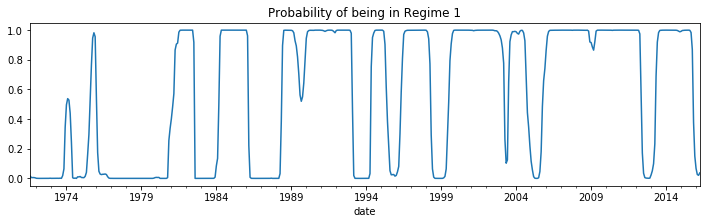

In [17]:
regime_model = sm.tsa.MarkovRegression(
    df_combined['exret_annual10'].shift(-12), k_regimes=2, exog=exog[['tent', 'liq_resid1']],
    missing='drop', switching_variance=True)

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));

### Liquidity factor as residual 2

                        Markov Switching Model Results                        
Dep. Variable:         exret_annual10   No. Observations:                  537
Model:               MarkovRegression   Log Likelihood                 738.286
Date:                Fri, 03 Nov 2017   AIC                          -1456.571
Time:                        11:30:08   BIC                          -1413.711
Sample:                    08-31-1971   HQIC                         -1439.805
                         - 04-30-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0702      0.006    -12.317      0.000      -0.081      -0.059
x1             1.7164      0.278      6.181      0.0

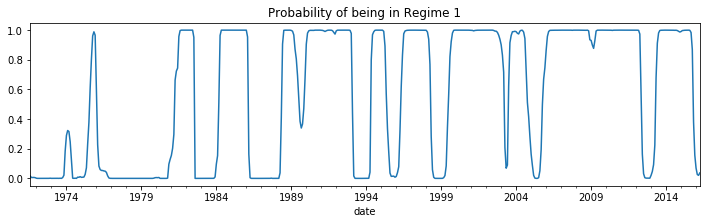

In [18]:
regime_model = sm.tsa.MarkovRegression(
    df_combined['exret_annual10'].shift(-12), k_regimes=2, exog=exog[['tent', 'liq_resid2']],
    missing='drop', switching_variance=True)

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));

### Liquidity factor as Svensson deviation

                        Markov Switching Model Results                        
Dep. Variable:         exret_annual10   No. Observations:                  537
Model:               MarkovRegression   Log Likelihood                 735.905
Date:                Fri, 03 Nov 2017   AIC                          -1451.809
Time:                        11:30:13   BIC                          -1408.949
Sample:                    08-31-1971   HQIC                         -1435.043
                         - 04-30-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0727      0.007    -10.186      0.000      -0.087      -0.059
x1             1.8192      0.295      6.163      0.0

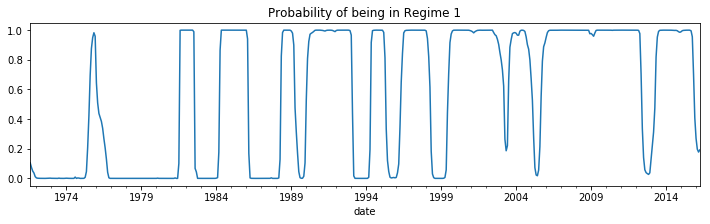

In [19]:
regime_model = sm.tsa.MarkovRegression(
    df_combined['exret_annual10'].shift(-12), k_regimes=2, exog=exog[['tent', 'liq_sven']],
    missing='drop', switching_variance=True)

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));